In [1]:
from create_dataset import create_dataset
from script.train import train_models

In [9]:
# 공용 변수 정의
generation_count = 10000
n_min = 70
n_max = 140

In [3]:
# 데이터셋 생성
create_dataset(generation_count, n_min, n_max)

===== Creating dataset: ascending_triangle =====
1/10000 Done
2/10000 Done
3/10000 Done
4/10000 Done
5/10000 Done
6/10000 Done
7/10000 Done
8/10000 Done
9/10000 Done
10/10000 Done
11/10000 Done
12/10000 Done
13/10000 Done
14/10000 Done
15/10000 Done
16/10000 Done
17/10000 Done
18/10000 Done
19/10000 Done
20/10000 Done
21/10000 Done
22/10000 Done
23/10000 Done
24/10000 Done
25/10000 Done
26/10000 Done
27/10000 Done
28/10000 Done
29/10000 Done
30/10000 Done
31/10000 Done
32/10000 Done
33/10000 Done
34/10000 Done
35/10000 Done
36/10000 Done
37/10000 Done
38/10000 Done
39/10000 Done
40/10000 Done
41/10000 Done
42/10000 Done
43/10000 Done
44/10000 Done
45/10000 Done
46/10000 Done
47/10000 Done
48/10000 Done
49/10000 Done
50/10000 Done
51/10000 Done
52/10000 Done
53/10000 Done
54/10000 Done
55/10000 Done
56/10000 Done
57/10000 Done
58/10000 Done
59/10000 Done
60/10000 Done
61/10000 Done
62/10000 Done
63/10000 Done
64/10000 Done
65/10000 Done
66/10000 Done
67/10000 Done
68/10000 Done
69/10000

In [ ]:
# 모델 학습 및 파일 저장
train_models()

In [76]:
import os
import numpy as np
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt  # 추가된 부분
from matplotlib.lines import Line2D  # 레전드 추가를 위한 Line2D
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# OHLC 데이터를 불러와서 n_min과 슬라이딩 윈도우 방식으로 데이터를 분할하는 함수
def load_and_split_data(df, n_min):
    ohlc_data = df[['Open', 'High', 'Low', 'Close']].values

    # 데이터를 분할할 리스트
    split_data = []
    scaler = StandardScaler()

    # n_min에서 시작해서 1씩 증가하며 데이터를 분할
    for length in range(n_min, len(ohlc_data) + 1):
        for start in range(len(ohlc_data) - length + 1):
            segment = ohlc_data[start:start + length]
            
            # 데이터 스케일링
            segment_scaled = scaler.fit_transform(segment)
            
            # 고정된 길이로 패딩 (모델의 입력 크기인 100으로 패딩)
            padded_segment = pad_sequences([segment_scaled], maxlen=100, padding='post', dtype='float32')[0]
            split_data.append(padded_segment)

    split_data = np.array(split_data)

    # split_data가 비어 있는지 확인
    if split_data.size == 0:
        print("split_data is empty, check if n_min is too large or data loading failed.")
    
    print(f"split_data shape: {split_data.shape}")  # 데이터 형태 확인
    return split_data

# CNN과 LSTM 모델을 적용하여 확률을 반환하는 함수
def predict_with_models(cnn_model, lstm_model, split_data):
    try:
        cnn_predictions = cnn_model.predict(split_data)
        lstm_predictions = lstm_model.predict(split_data)
        return cnn_predictions, lstm_predictions
    except:
        print('Error while calculating model prediction')
        return None, None

# 패턴 리스트 및 색상 정의
pattern_list = ['ascending_triangle', 'ascending_wedge', 'descending_triangle', 'descending_wedge', 'double_top', 'double_bottom']
pattern_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

# OHLC 데이터에 대한 차트 그리기 함수
def plot_with_predictions(df, cnn_high_segments, lstm_high_segments, cnn_patterns, lstm_patterns):
    # 차트 그리기 위한 데이터 준비
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # 강조할 구간을 표시하기 위한 빈 리스트
    alines_cnn = []
    alines_lstm = []
    annotations = []

    # CNN 감지 구간 처리
    if cnn_high_segments:
        for idx, (start, end) in enumerate(cnn_high_segments):
            if start < len(df) and end <= len(df):
                pattern_idx = cnn_patterns[idx]
                color = pattern_colors[pattern_idx]
                for i in range(start, end - 1):
                    # x축(Timestamp), y축(Close) 값으로 구간을 추가
                    alines_cnn.append([(df.index[i], df['Close'].iloc[i]), (df.index[i + 1], df['Close'].iloc[i + 1])])
                annotations.append((df.index[end-1], df['Close'].iloc[end-1], pattern_list[pattern_idx], color))

    # LSTM 감지 구간 처리
    if lstm_high_segments:
        for idx, (start, end) in enumerate(lstm_high_segments):
            if start < len(df) and end <= len(df):
                pattern_idx = lstm_patterns[idx]
                color = pattern_colors[pattern_idx]
                for i in range(start, end - 1):
                    # x축(Timestamp), y축(Close) 값으로 구간을 추가
                    alines_lstm.append([(df.index[i], df['Close'].iloc[i]), (df.index[i + 1], df['Close'].iloc[i + 1])])
                annotations.append((df.index[end-1], df['Close'].iloc[end-1], pattern_list[pattern_idx], color))

    # CNN 차트 그리기
    if alines_cnn:
        mpf.plot(df, type='candle', style='charles', title='CNN Prediction',
                 alines=dict(alines=alines_cnn, colors=[pattern_colors[pattern_idx] for pattern_idx in cnn_patterns], linewidths=1),
                 figratio=(12, 8), figscale=1.5)

    # LSTM 차트 그리기
    if alines_lstm:
        mpf.plot(df, type='candle', style='charles', title='LSTM Prediction',
                 alines=dict(alines=alines_lstm, colors=[pattern_colors[pattern_idx] for pattern_idx in lstm_patterns], linewidths=1),
                 figratio=(12, 8), figscale=1.5)

    # 레전드 추가 (Line2D 객체를 사용해 수동으로 추가)
    legend_elements = [Line2D([0], [0], color=color, lw=2, label=pattern)
                       for pattern, color in zip(pattern_list, pattern_colors)]
    plt.legend(handles=legend_elements)

# 확률을 반환하는 메인 함수 (threshold를 추가)
def evaluate_ohlc_data(df, n_min, cnn_model_path, lstm_model_path, threshold=95):
    pattern_list = ['ascending_triangle', 'ascending_wedge', 'descending_triangle', 'descending_wedge', 'double_top', 'double_bottom']

    # 모델 로드
    cnn_model = load_model(cnn_model_path)
    lstm_model = load_model(lstm_model_path)

    # 데이터를 분할하여 준비
    split_data = load_and_split_data(df, n_min)

    # CNN과 LSTM 모델로 예측
    cnn_predictions, lstm_predictions = predict_with_models(cnn_model, lstm_model, split_data)
    
    cnn_high_segments = []
    lstm_high_segments = []
    cnn_patterns = []
    lstm_patterns = []

    # 각 분할된 데이터에 대해 클래스별 확률을 퍼센트로 반환
    for i, (cnn_pred, lstm_pred) in enumerate(zip(cnn_predictions, lstm_predictions)):
        # CNN과 LSTM의 확률값을 100으로 변환
        cnn_pred_percent = 100 * cnn_pred
        lstm_pred_percent = 100 * lstm_pred

        # CNN에서 threshold 이상의 확률이 있는 경우
        if np.any(cnn_pred_percent > threshold):
            cnn_high_segments.append((i, i + n_min))  # 구간 추가
            cnn_patterns.append(np.argmax(cnn_pred_percent))

        # LSTM에서 threshold 이상의 확률이 있는 경우
        if np.any(lstm_pred_percent > threshold):
            lstm_high_segments.append((i, i + n_min))  # 구간 추가
            lstm_patterns.append(np.argmax(lstm_pred_percent))

    # 그래프 그리기
    plot_with_predictions(df, cnn_high_segments, lstm_high_segments, cnn_patterns, lstm_patterns)

split_data shape: (1081, 100, 4)
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


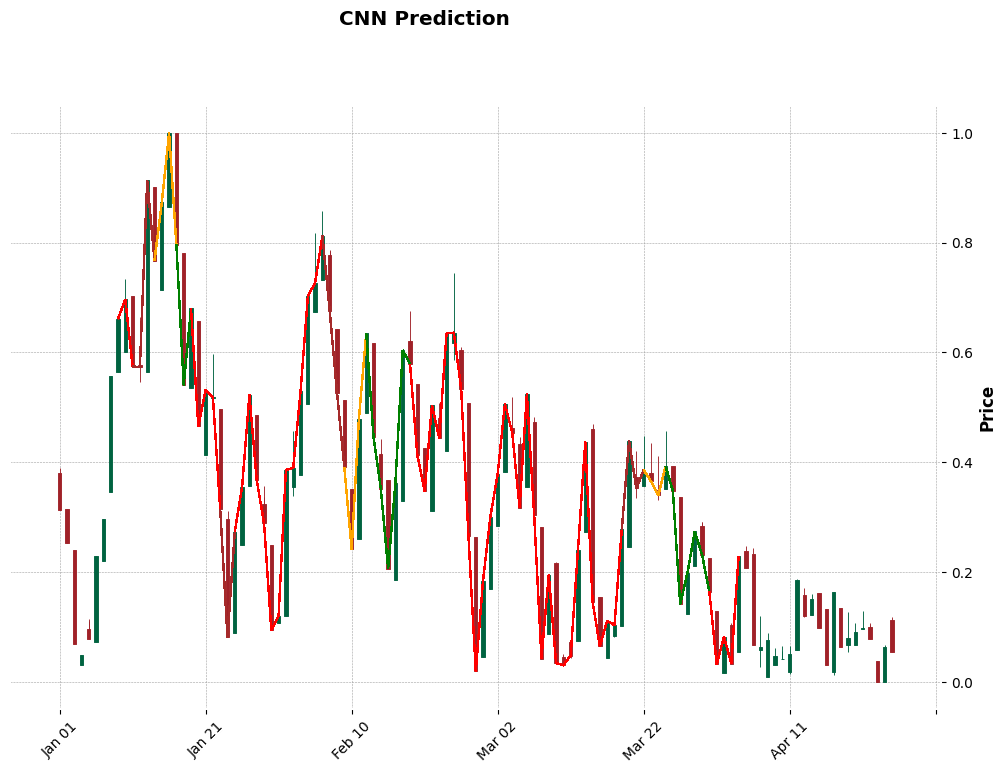

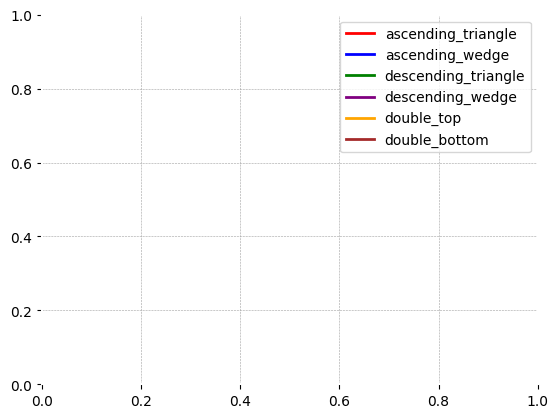

In [77]:
# # 사용 예시
# path = './algo_dataset/descending_triangle/descending_triangle_1.csv'  # 예측할 OHLC 데이터 경로
# cnn_model_path = './save/cnn_chart_pattern_model.keras'  # CNN 모델 경로
# lstm_model_path = './save/lstm_chart_pattern_model.keras'  # LSTM 모델 경로
# threshold = 97  # 확률 threshold 설정

# # 평가 함수 호출
# evaluate_ohlc_data(path, n_min, cnn_model_path, lstm_model_path, threshold)

# 사용 예시
df = pd.read_csv('./algo_dataset/descending_wedge/descending_wedge_1.csv')  # OHLC 데이터 경로
n_min = 70  # 시작 시 최소 데이터 수
cnn_model_path = './save/cnn_chart_pattern_model.keras'  # CNN 모델 경로
lstm_model_path = './save/lstm_chart_pattern_model.keras'  # LSTM 모델 경로
threshold = 95  # 확률 threshold 설정

# 평가 함수 호출
evaluate_ohlc_data(df, n_min, cnn_model_path, lstm_model_path, threshold)


split_data shape: (1431, 100, 4)
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


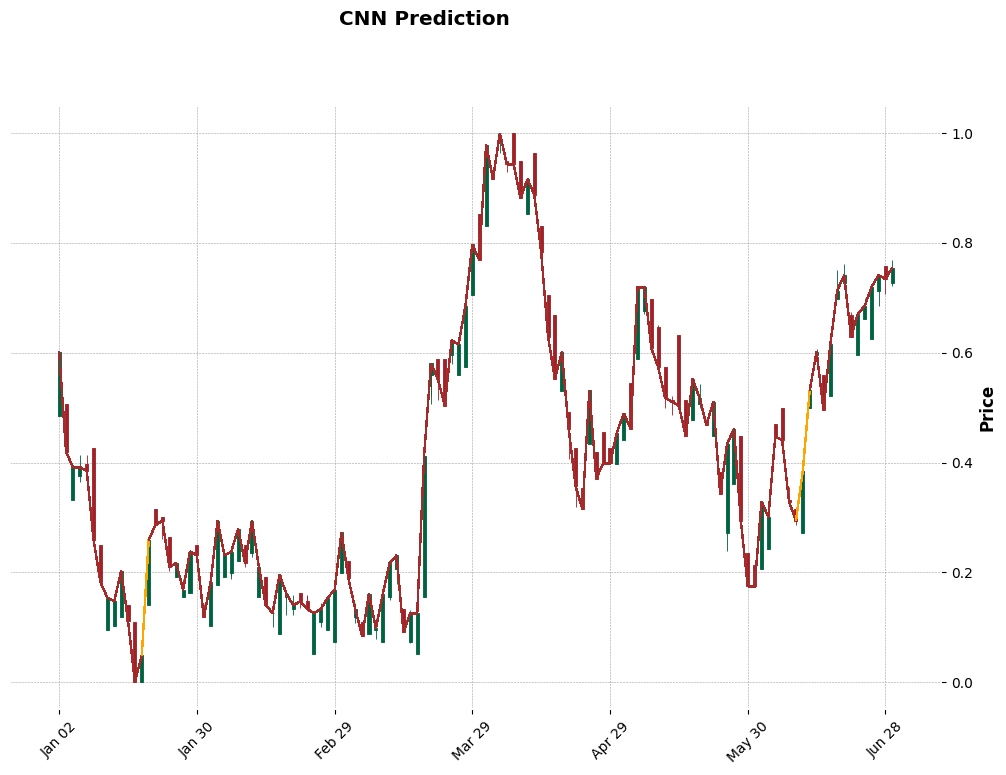

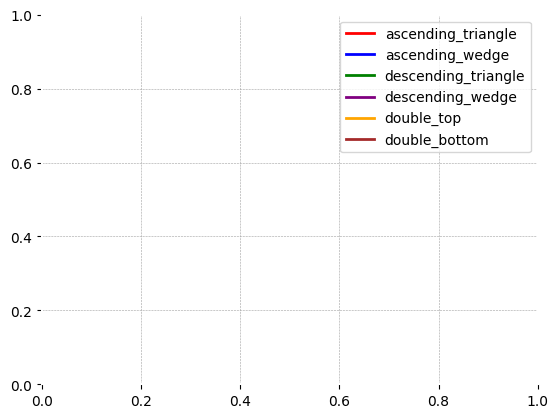

In [87]:
import pandas as pd
from pykrx import stock
from sklearn.preprocessing import MinMaxScaler

def transform_dataframe(df):
    # 변환할 컬럼 선택 (시가, 고가, 저가, 종가)
    columns_to_scale = ['시가', '고가', '저가', '종가']
    
    # MinMaxScaler를 사용하여 데이터를 0~1 사이로 변환
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[columns_to_scale])
    
    # 변환된 데이터를 새로운 데이터프레임으로 저장
    transformed_df = pd.DataFrame(scaled_values, columns=['Open', 'High', 'Low', 'Close'], index=df.index)
    
    # 인덱스 이름 변경
    transformed_df.index.name = 'Date'

    # 인덱스를 일반 컬럼으로 변환
    transformed_df = transformed_df.reset_index()  # 인덱스를 일반 컬럼으로 변환
    
    return transformed_df

price_df = stock.get_market_ohlcv("20240101", "20240701", "005930")
price_df = transform_dataframe(price_df)

cnn_model_path = './save/cnn_chart_pattern_model.keras'  # CNN 모델 경로
lstm_model_path = './save/lstm_chart_pattern_model.keras'  # LSTM 모델 경로
threshold = 99  # 확률 threshold 설정

# 평가 함수 호출
evaluate_ohlc_data(price_df, n_min, cnn_model_path, lstm_model_path, threshold)
